# Making 2-D Laplacian inversion matrices in to order to visualize it

In [1]:
import itertools
from sympy import init_printing
from sympy import symbols
from sympy import Matrix, diag
from IPython.display import display

init_printing()

Creating dimensions

In [2]:
# Note, these can be max 9 due to the current index convention
nx = 3 # Not including ghost points
nz = 3

startXIndex = 10 # The x indices are the slowest growing indices
startZIndex = 1  # The z indices are the fastest growing indices

## Creating the points in the mesh

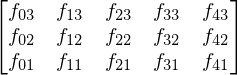

In [3]:
# The function at the current point
f = []
for z in range(nz):
    f.append([])
    xStart = startZIndex
    xEnd   = startXIndex*(nx+1)  # +1 due to ghost point
    # +startXIndex in the range as the range does not include endpoint
    for xInd in range(xStart, xEnd+startXIndex, 10):
        ind = str(xInd+z)
        if (xInd+z) < startXIndex:
            ind = '0'+str(xInd+z)
        f[z].append(symbols('f_' + ind))

mesh = Matrix(f[::-1])
display(mesh)

Do the vectors

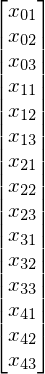

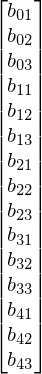

In [4]:
xVec=[]
bVec=[]
# Do the inner loop, so start ranges at 1
# (nx+1) to include outer ghost point, +1 in the range as the range does not include endpoint
for x in range(1, (nx+1)+1):
    for z in range(1,nz+1):
        xVec.append(symbols('x_'+str(x)+'_'+str(z)))
        bVec.append(symbols('b_'+str(x)+'_'+str(z)))

# Do the inner ghost points
# Must count backwards since we are inserting in the front
for ind in range(nz,0,-1):
    xVec.insert(0, symbols('x_0_'+str(ind)))
    bVec.insert(0, symbols('b_0_'+str(ind)))
    
display(Matrix(xVec))
display(Matrix(bVec))

## Make the global index matrix

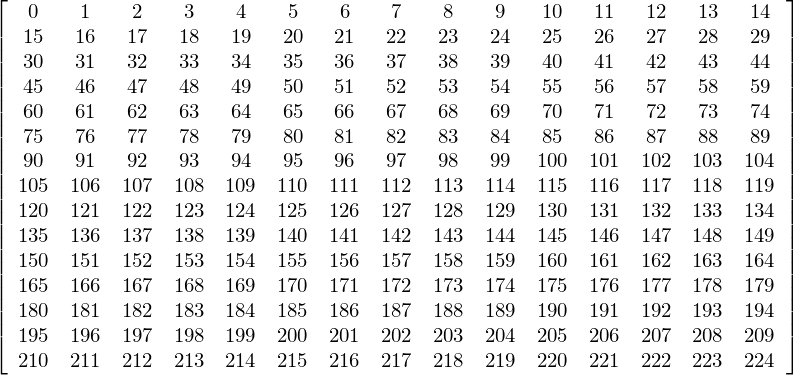

In [5]:
globInd = []
for rows in range(len(xVec)):
    cols = []
    for col in range(rows*len(xVec), (rows+1)*len(xVec)):
        cols.append(col)
    globInd.append(cols)

display(Matrix(globInd))

## Make the inversion matrix

### Make the diagonal for the inner points

In [6]:
c = []
for x in range(nx):
    indexStart = (startXIndex+1)+(startXIndex*x)     # Multiply by 10 due to index system
    indexEnd   = (startXIndex+nz+1)+(startXIndex*x)  # Multiply by 10 due to index system
    for ind in range(indexStart, indexEnd):
        c.append(symbols('c_'+str(ind)))

### Make the ghost points

In [7]:
# The inner ghost
innerGhostStart = startZIndex
innerGhostEnd   = nz
ig = []
# +1 in the range as last point is not included
for z in range(innerGhostStart, innerGhostEnd+1):
    ig.append(symbols('ig_0_'+str(z)))

In [8]:
# The outer ghost
outerGhostStart = startXIndex*nz + startZIndex
outerGhostEnd   = startXIndex*nz + nz
og = []
# +1 in the range as last point is not included
for z in range(outerGhostStart, outerGhostEnd+1):
    og.append(symbols('og_'+str(z)))

### Create the diagonal of the matrix

In [9]:
InvM = diag(*ig, *c, *og)

### Create the non-diagonal values

#### Set z+1 values

In [10]:
for x in range(nx):
    # The indices referring to the matrix index
    # The last -1 is there as the matrix indices count from 0
    startRow = (nz+1)+(x*nz)-1  # Starting at row+1 after inner ghost point sub-matrix
    endRow   = (nz+1)+(x*nz)+(nz-1)-1 # Ending row-1 before the last z-index (last z will be wrapped around)
    # +1 in range as last point is not included
    rows     = range(startRow,   endRow+1)
    cols     = range(startRow+1, endRow+1) # Column is shifted +1 from the diagonal
    
    # The indices referring to the spatial point in the grid
    # The last "+1" is fue to the fact that the column is shifted +1 from the diagonal
    startInd = (startXIndex+startZIndex) + (startXIndex*x) + 1
    endInd   = (startXIndex+startZIndex) + (nz-1) + (startXIndex*x) + 1 # Wrap around last point
    # +1 in range as last point is not included
    inds     = range(startInd, endInd+1)
    
    for rInd, cInd, ind in zip(rows, cols, inds):
        InvM[rInd, cInd] = symbols('zp_'+str(ind))

In [11]:
# The wrap around
# The index referring to the spatial point in the grid
startInd = startXIndex+startZIndex
# The indices referring to the matrix index
# Last -1 as the matrix indices are counted from 0 
startRow = (nz+1) + (nz-1) - 1 # nz+1 below from the ghost sub matrix, nz-1 below after that
startCol = (nz+1)-1            # nz+1 left of the ghost sub matrix
for wrap in range(nx):
    row = startRow+wrap*nz
    col = startCol+wrap*nz
    InvM[row, col] = symbols('zp_'+str(startInd+startXIndex*wrap))

#### Set z-1 values

In [12]:
for x in range(nx):
    # The indices referring to the matrix index
    # The last -1 is there as the matrix indices count from 0
    startRow = (nz+1)+(x*nz)-1  # Starting at row+1 after inner ghost point sub-matrix
    endRow   = (nz+1)+(x*nz)+(nz-1)-1 # Ending row-1 before the last z-index (last z will be wrapped around)
    # +1 in range as last point is not included
    rows     = range(startRow+1, endRow+1) # Row is shifted +1 from the diagonal
    cols     = range(startRow,   endRow+1)
    
    # The indices referring to the spatial point in the grid
    startInd = (startXIndex+startZIndex) + (startXIndex*x)
    endInd   = (startXIndex+startZIndex) + (nz-1) + (startXIndex*x) # Wrap around last point
    # +1 in range as last point is not included
    inds     = range(startInd, endInd+1)
    
    for rInd, cInd, ind in zip(rows, cols, inds):
        InvM[rInd, cInd] = symbols('zm_'+str(ind))

In [13]:
# The wrap around
# The index referring to the spatial point in the grid
startInd = startXIndex+startZIndex+(nz-1) # +(nz-1) as this will be the last z point for the current x
# The indices referring to the matrix index
# Last -1 as the matrix indices are counted from 0 
startRow = (nz+1)-1            # nz+1 below the ghost sub matrix
startCol = (nz+1) + (nz-1) - 1 # nz+1 left from the ghost sub matrix, nz-1 left after that
for wrap in range(nx):
    row = startRow+wrap*nz
    col = startCol+wrap*nz
    InvM[row, col] = symbols('zm_'+str(startInd+startXIndex*wrap))

#### Set x+1 values

In [14]:
# Indices referring to the spatial points in the grid
startInd = startXIndex*2 + startZIndex # *2 as we start at the second inner x-index
endInd   = startInd + (startZIndex*nz) # *nz as this is the last z-index in the current x-index

for x in range(nx):
    # The indices referring to the matrix index
    # The last -1 as the matrix indices counts from 0
    startRow = (nz+1)+(x*nz)-1      # Starting at row+1 after inner ghost point sub-matrix
    endRow   = (nz+1)+(x*nz)+(nz)-1 # Ending at the row referring to the last z-index
    # Not +1 in range as we do not want to include last point
    rows     = range(startRow,    endRow)
    cols     = range(startRow+nz, endRow+nz)           # Start at first index after last z-index
    
    # Indices referring to the spatial points in the grid
    inds     = range(startInd+startXIndex*x, endInd+startXIndex*x)
    
    for rInd, cInd, ind in zip(rows, cols, inds):
        InvM[rInd, cInd] = symbols('xp_'+str(ind))

In [15]:
# x+1 for inner ghost point
# Indices referring to the spatial points in the grid
startInd = startXIndex + startZIndex   # First inner point for first z
endInd   = startInd + (startZIndex*nz) # First inner point for last z

# The indices referring to the matrix index
# The last -1 as the matrix indices counts from 0
startRow = startZIndex-1    # Starting at first row
endRow   = startZIndex+nz-1 # Ending at the row referring to the last z-index
# Not +1 in range as we do not want to include last point
rows     = range(startRow,    endRow)
cols     = range(startRow+nz, endRow+nz)           # Start at first index after last z-index
    
# Indices referring to the spatial points in the grid
inds     = range(startInd, endInd)
    
for rInd, cInd, ind in zip(rows, cols, inds):
    InvM[rInd, cInd] = symbols('igxp_'+str(ind))

#### Set x-1 values

In [16]:
# Indices referring to the spatial points in the grid
startInd = startZIndex
endInd   = startInd + nz

for x in range(nx):
    # The indices referring to the matrix index
    # Note that x starts counting from zero, so we must add 1 to x in the rows
    startRow = ((x+1)*nz)      # Starting at row+1 after inner ghost point sub-matrix
    endRow   = ((x+1)*nz)+(nz) # Ending at the row referring to the last z-index
    # Not +1 in range as we do not want to include last point
    rows = range(startRow,    endRow)
    cols = range(startRow-nz, endRow-nz)           # Start at first index after last z-index
    
    # Indices referring to the spatial points in the grid
    inds = range(startInd+startXIndex*x, endInd+startXIndex*x)
    
    for rInd, cInd, ind in zip(rows, cols, inds):
        if (ind) < startXIndex:
            ind = '0'+str(ind)

        InvM[rInd, cInd] = symbols('xm_'+str(ind))

In [17]:
# x-1 for inner ghost point
# Indices referring to the spatial points in the grid
startInd = startXIndex*nx + startZIndex   # Last inner point for first z
endInd   = startInd + (startZIndex*nz)    # Last inner point for last z

# The indices referring to the matrix index
# The last -1 as the matrix indices counts from 0
startRow = len(xVec)-nz-1    # Starting at last inner point row
endRow   = len(xVec)-1       # Ending at the last row
# +1 in range as last point is not included
rows     = range(startRow+1,    endRow+1)
cols     = range(startRow-nz+1, endRow-nz+1) # Start at first index after last z-index
    
# Indices referring to the spatial points in the grid
inds     = range(startInd, endInd)
    
for rInd, cInd, ind in zip(rows, cols, inds):
    InvM[rInd, cInd] = symbols('ogxm_'+str(ind))

### Display the matrix

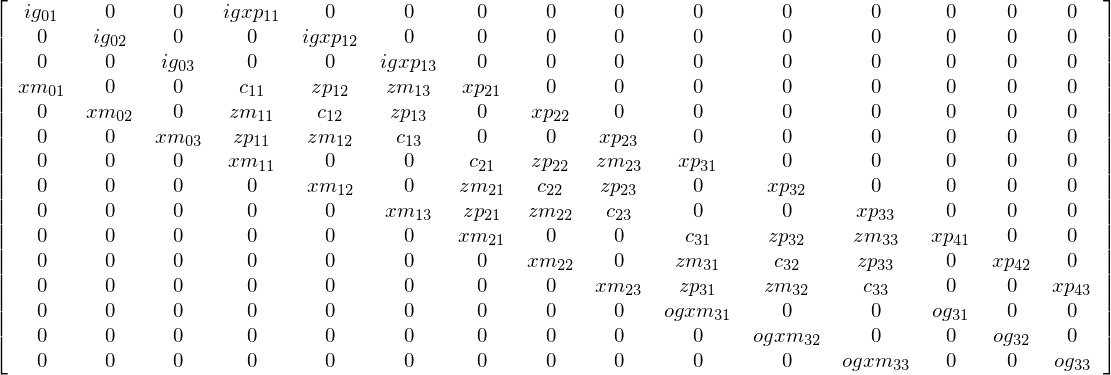

In [18]:
display(InvM)